<a href="https://colab.research.google.com/github/Apurva-cuj/cybersecurity/blob/master/Cuzzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Embedding Database Notebook
This notebook produces a database of embeddings converted from the trained graphs using the best model from training.

In [1]:
!nvidia-smi

Fri Jun  4 14:35:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/cybersecurity-master')

In [4]:
# imports 
import tensorflow as tf
import numpy as np
from graphnnSiamese import graphnn
from utils import * 
import os
import json
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [5]:
!pwd

/content


In [6]:
cd /content/drive/MyDrive/cybersecurity-master

/content/drive/MyDrive/cybersecurity-master


In [7]:
# unzip data zip file
!unzip data.zip

Archive:  data.zip
replace data/class_perm.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [8]:
# set up of the model 
os.environ["CUDA_VISIBLE_DEVICES"]='0'
Dtype = tf.float32
NODE_FEATURE_DIM = 7
EMBED_DIM = 64
EMBED_DEPTH = 2
OUTPUT_DIM = 64
ITERATION_LEVEL = 5
#LEARNING_RATE = tf.cast(1e-4,'float32')
#LEARNING_RATE = tf.as_dtype(1e-4)
LEARNING_RATE = 1e-4

tf.compat.v1.disable_eager_execution()
BATCH_SIZE = 2
LOAD_PATH= None
#LOAD_PATH = 'graphnn-model_best'
LOG_PATH = 'log.txt'

DATA_FILE_NAME = './data/acfgSSL_{}/'.format(NODE_FEATURE_DIM)
SOFTWARE=('openssl-1.0.1f-', 'openssl-1.0.1u-')
OPTIMIZATION=('-O0', '-O1','-O2','-O3')
COMPILER=('armeb-linux', 'i586-linux', 'mips-linux')
VERSION=('v54',)


gnn = graphnn(
        N_x = NODE_FEATURE_DIM,
        Dtype = Dtype, 
        N_embed = EMBED_DIM,
        depth_embed = EMBED_DEPTH,
        N_o = OUTPUT_DIM,
        ITER_LEVEL = ITERATION_LEVEL,
       # lr="0.0001"
        lr = LEARNING_RATE
      )
gnn.init(LOAD_PATH, LOG_PATH)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

Training start @ 2021-06-04 14:35:51.060636


In [9]:
FUNC_NAME_DICT = {}

# Process the input graphs
F_NAME = get_f_name(DATA_FILE_NAME, SOFTWARE, COMPILER,
        OPTIMIZATION, VERSION)
FUNC_NAME_DICT = get_f_dict(F_NAME)


Gs, classes = read_graph(F_NAME, FUNC_NAME_DICT, NODE_FEATURE_DIM)
print("{} graphs, {} functions".format(len(Gs), len(classes)))


if os.path.isfile('data/class_perm.npy'):
    perm = np.load('data/class_perm.npy')
else:
    perm = np.random.permutation(len(classes))
    np.save('data/class_perm.npy', perm)
if len(perm) < len(classes):
    perm = np.random.permutation(len(classes))
    np.save('data/class_perm.npy', perm)

Gs_train, classes_train, Gs_dev, classes_dev, Gs_test, classes_test =\
        partition_data(Gs,classes,[0.8,0.1,0.1], perm)

print("Train: {} graphs, {} functions".format(len(Gs_train), len(classes_train)))
print("Dev: {} graphs, {} functions".format(len(Gs_dev), len(classes_dev)))
print("Test: {} graphs, {} functions".format(len(Gs_test), len(classes_test)))

129365 graphs, 7305 functions
Train: 103732 graphs, 5844 functions
Dev: 12726 graphs, 730 functions
Test: 12907 graphs, 731 functions


Get embeddings for each set of data

In [10]:
train = get_vec(gnn, Gs_train, classes_train, BATCH_SIZE)

In [11]:
vali = get_vec(gnn, Gs_dev, classes_dev, BATCH_SIZE)

In [12]:
test = get_vec(gnn, Gs_test, classes_test, BATCH_SIZE)

A list of function names from the t-SNE shown in [the paper](https://arxiv.org/pdf/1708.06525.pdf)

In [13]:
lst = ['v2i_POLICY_MAPPINGS', 'genrsa_main', 'priv_decode_gost', 'prompt_info', 'ssl3_get_message']

key: unique list of labels matching the list above

In [14]:
labels = []
for i in Gs:
  if i.fname in lst:
    labels.append(i.label)
key = list(set(labels))

Convert get_vec() output dictionary into a dictionary with:

- keys: class label/id
- values: list of all embeddings of the same class

In [15]:
train_cls_dict = {}

counter = 0

for k in train.keys():
  cls_id = train[k][0]
  if cls_id in train_cls_dict.keys():
    train_cls_dict[cls_id].append(train[k][1])
  else:
    train_cls_dict[cls_id] = [train[k][1]]
    
  counter += 1
  
  if counter == 100000:
    break
  

In [16]:
vali_cls_dict = {}

counter = 0

for k in vali.keys():
  cls_id = vali[k][0]
  if cls_id in vali_cls_dict.keys():
    vali_cls_dict[cls_id].append(vali[k][1])
  else:
    vali_cls_dict[cls_id] = [vali[k][1]]
    
  counter += 1
  
  if counter == 100000:
    break
  

In [17]:
test_cls_dict = {}

counter = 0

for k in test.keys():
  cls_id = test[k][0]
  if cls_id in test_cls_dict.keys():
    test_cls_dict[cls_id].append(test[k][1])
  else:
    test_cls_dict[cls_id] = [test[k][1]]
    
  counter += 1
  
  if counter == 100000:
    break
  

Get all embeddings and labels in list type

In [18]:
train_embs = []
train_labels1 = []

for i in train_cls_dict.keys():
  cnt = len(train_cls_dict[i])
  for j in range(cnt):
    train_labels1.append(i)
  
    train_embs.append(train_cls_dict[i][j])

In [19]:
vali_embs = []
vali_labels1 = []

for i in vali_cls_dict.keys():
  cnt = len(vali_cls_dict[i])
  for j in range(cnt):
    vali_labels1.append(i)
  
    vali_embs.append(vali_cls_dict[i][j])

In [20]:
test_embs = []
test_labels1 = []

for i in test_cls_dict.keys():
  cnt = len(test_cls_dict[i])
  for j in range(cnt):
    test_labels1.append(i)
  
    test_embs.append(test_cls_dict[i][j])

t-SNE plot with cosine metric

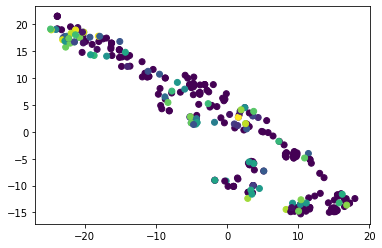

In [21]:
model = TSNE(metric='cosine', n_iter=10000)
transformed = model.fit_transform(train_embs)

x = transformed[:,0]
y = transformed[:,1]
plt.scatter(x, y, c=train_labels1)
plt.show()

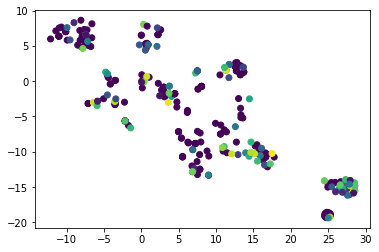

In [22]:
model = TSNE(metric='cosine', n_iter=10000)
transformed = model.fit_transform(vali_embs)

x = transformed[:,0]
y = transformed[:,1]
plt.scatter(x, y, c=vali_labels1)
plt.show()

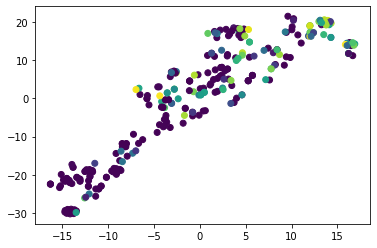

In [23]:
model = TSNE(metric='cosine', n_iter=10000)
transformed = model.fit_transform(test_embs)

x = transformed[:,0]
y = transformed[:,1]
plt.scatter(x, y, c=test_labels1)
plt.show()

For Tensorflow Projector used only

In [24]:
f = open("tsne-data.tsv", "w")
for i in embs:
  for j in range(64):
    f.write("%f\t" %i[j])
  f.write("\n")
f.flush()
f.close()

NameError: ignored

In [ ]:
f1 = open("labels.tsv", "w")
for i in labels1:
  f1.write("%d\n" %i)
f1.flush()
f1.close()

In [ ]:
print ("Hello ")

In [ ]:
python 

In [ ]:
!python3 eval.py

In [ ]:
f = open("demofile2.txt", "w")
f.write(str(1))
f.write("\t")
f.write(str(2))
f.close()
